In [2]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [3]:
from analysis_funcs import *
from external_flux import *

In [4]:
import glob
import re

In [5]:
getobmt = lambda x: int(re.search("(?<=OBMT_START_)[0-9]+",x).group(0))

# In SM

In [6]:
# get all paths
allpaths = glob.glob("../output/*/*/*/SM-SIF_OBMT_START_*.fits")
allpaths.sort(key = getobmt)

In [7]:
pathtimes_rev = np.array([getobmt(p) for p in allpaths])/(1e9*3600*6)

def psel_rev(start,stop):
    indices = np.where(np.logical_and(pathtimes_rev>=start, pathtimes_rev<=stop))[0]
    return [allpaths[ii] for ii in indices]


pathtimes_mjd = OBMT_apyTime(np.array([getobmt(p) for p in allpaths])).mjd

def psel_mjd(start,stop):
    indices = np.where(np.logical_and(pathtimes_mjd>=start, pathtimes_mjd<=stop))[0]
    return [allpaths[ii] for ii in indices]

In [8]:
len(allpaths)

1136

# Energy histograms

In [10]:
testE = fits_energies_edgeless(psel_mjd(57500,57550))

In [11]:
#testE2 = fits_energies_edgeless(psel_mjd(56715,56720))
testE2 = fits_energies_edgeless(psel_mjd(58006,58012))

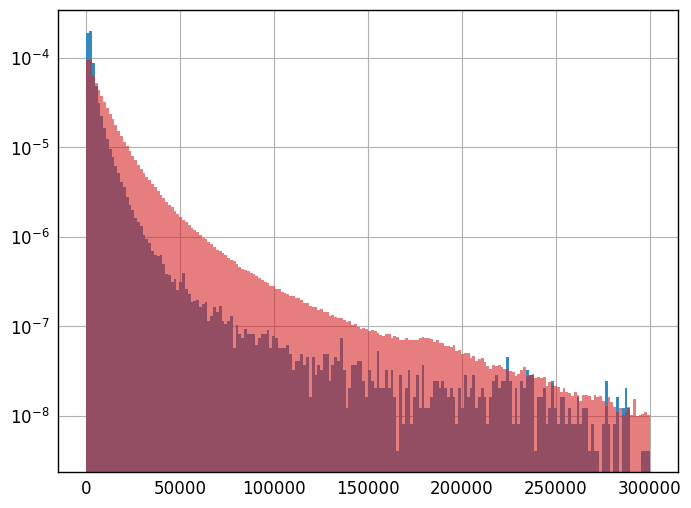

In [12]:
h1 = plt.hist(concatenate_energies(testE[1], range(len(testE[1]))), 200, range=(0,300000), normed=True, log=True)
h2 = plt.hist(concatenate_energies(testE2[1], range(len(testE2[1]))),200, range=(0,300000),normed=True, log=True,
                 color="tab:red", alpha=0.6)

Interesting very high energy behaviour, some sort of bump

Test: Instead of normalizing by the total number of particles, take the flux into account as well

In [34]:
# There is actually no need to go and calculate the geometry factors - we just need to normalize using the flux
# I.e.: The integral over the histogram (dE) has to be equal to the (mean, when using multiple obs) flux!

flux1 = fits_flux(psel_mjd(57500,57550))[2]
flux2 = fits_flux(psel_mjd(58006,58012))[2]

In [35]:
def energyHist_fluxnormed(obsEn, obsFluxes, bins=None, enrange=None):
    """
    Given a list of energy arrays and a list of the fluxes of the corresponding observations,
    make a normed energy histogram - each observation is normed by its geometry factor and then averaged over
    The output histogram is counts/cm^2/s/eV
    """
    nobs = len(obsFluxes)
    Eflat = concatenate_energies(obsEn, range(nobs))
    normflat = np.empty(len(Eflat))
    
    # determine the weights
    start = 0
    for ii in range(nobs):
        nParticles = len(obsEn[ii])
        normflat[start:start+nParticles] = obsFluxes[ii]/nParticles
        start += +nParticles
    
    normflat /= nobs
    # compute the weighted histogram
    histout = np.histogram(Eflat,bins=bins,range=enrange, weights=normflat)
    
    # divide by bin size
    step = histout[1][1] - histout[1][0]
    #step=1
    
    return histout[0]/step, histout[1]

In [36]:
nhist1 = energyHist_fluxnormed(testE[1],flux1,200,(0,300000))
nhist2 = energyHist_fluxnormed(testE2[1][100:200],flux2[100:200],200,(0,300000))

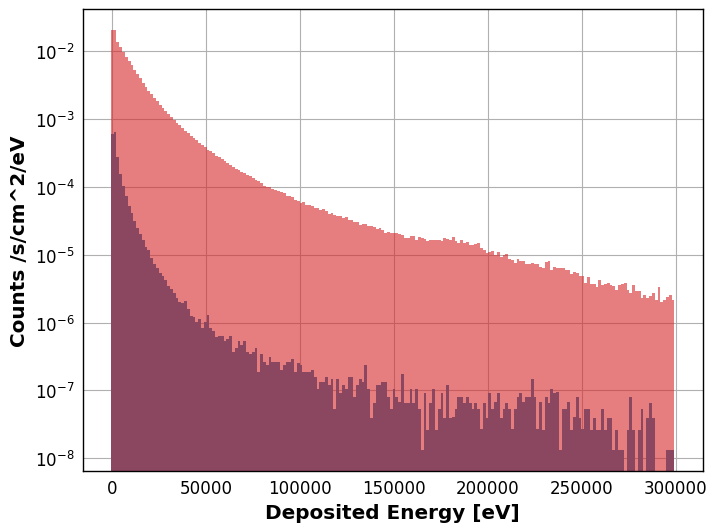

In [37]:
plt.bar(nhist1[1][:len(nhist1[0])], nhist1[0], nhist1[1][1]-nhist1[1][0], color="tab:blue")
plt.bar(nhist2[1][:len(nhist2[0])], nhist2[0], nhist2[1][1]-nhist2[1][0], color="tab:red",alpha=0.6)

plt.xlabel("Deposited Energy [eV]")
plt.ylabel("Counts /s/cm^2/eV")

plt.yscale('log')